In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/indian-pines-hyperspectral-dataset.zip .
!cp /content/drive/My\ Drive/models/best_3dGAN.h5 .

In [3]:
!unzip indian-pines-hyperspectral-dataset.zip

Archive:  indian-pines-hyperspectral-dataset.zip
  inflating: indianpinearray.npy     
  inflating: IPgt.npy                


In [0]:
import numpy as np
data = np.load('indianpinearray.npy')
gt = np.load('IPgt.npy')


In [0]:
from numpy.random import seed
seed(42)


from tensorflow import set_random_seed
set_random_seed(42)


In [0]:
# from sklearn.preprocessing import OneHotEncoder
H = data.shape[0]
W = data.shape[1]
# enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
# gt = enc.fit_transform(gt.reshape(-1,1))
# gt = gt.reshape(H,W,17)

In [0]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D,Conv1D,multiply
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
# from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D
from keras.initializers import RandomNormal
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from skimage.color import label2rgb
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import keras.backend as K
K.set_learning_phase(1)

In [0]:
from keras import applications, layers

class FrozenBatchNormalization(layers.BatchNormalization):
    def call(self, inputs, training=None):
        return super().call(inputs=inputs, training=False)

# Keep a copy of the original class
BatchNormalization = layers.BatchNormalization

# Patch the class temporarily
layers.BatchNormalization = FrozenBatchNormalization

In [0]:
def define_discriminator(in_shape=(64,64,3), n_classes=17):
	model = Sequential()

	model.add(Conv2D(64, kernel_size=(4,4), strides=2, input_shape=in_shape, padding="same"))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, kernel_size=(4,4), strides=2, padding="same"))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2D(256, kernel_size=(4,4), strides=2, padding="same"))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2D(512, kernel_size=(4,4), strides=2, padding="same"))
	model.add(LeakyReLU(alpha=0.2))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2D(64, kernel_size=(4,4), strides=1, padding="same"))

	model.add(Flatten())


	img = Input(shape=in_shape)
	features = model(img)
	validity = Dense(1, activation="sigmoid")(features)
	label = Dense(n_classes, activation="softmax")(features)
	model = Model(img, [validity, label])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.summary() 
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt,metrics=['accuracy'])
	return model

In [0]:
def define_generator(latent_dim, n_classes=17):
	model = Sequential()

	model.add(Dense(2*2*512, activation="relu", input_dim=latent_dim))
	model.add(Reshape((2,2, 512)))
	model.add(BatchNormalization(momentum=0.8))
	# model.add(UpSampling2D(size=4))

	model.add(Conv2DTranspose(512, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	# model.add(UpSampling2D(size=4))

	model.add(Conv2DTranspose(256, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	# model.add(UpSampling2D(size=4))

	model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	# model.add(UpSampling2D(size=4))

	model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	# model.add(UpSampling2D(size=4))

	model.add(Conv2DTranspose(3, kernel_size=(4,4), strides=2, padding='same'))
	model.add(Activation("tanh"))
	model.summary()

	noise = Input(shape=(latent_dim,))
	label = Input(shape=(1,), dtype='int32')
	label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))

	model_input = multiply([noise, label_embedding])
	img = model(model_input)
	model.summary()
	return Model([noise, label], img)

In [0]:
!pip install patchify

  Created wheel for patchify: filename=patchify-0.1.1-cp36-none-any.whl size=1972 sha256=8e0d5e8059da996038a58d9209581f11428e2ec53975f00aad99131d3768d4df
  Stored in directory: /root/.cache/pip/wheels/d9/80/60/b50557046af4fd5cf08b521288c5102af598f821c962794790
Successfully built patchify


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from patchify import patchify, unpatchify


voxel = data.reshape(-1,data.shape[2])
scaler = StandardScaler()
voxel = scaler.fit_transform(voxel)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(voxel)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(x) for x in range(3)])
fullDataX = principalComponents.reshape(H,W,3)
fullDataY = gt

import cv2
paddedDatax = cv2.copyMakeBorder( fullDataX, 32, 31, 32, 31, cv2.BORDER_REPLICATE)


X_train = patchify(paddedDatax, (64, 64, 3), step=1).reshape(-1,64,64,3)
y_train = fullDataY.reshape(-1,)

def generate_real_samples(n_samples):
	images, labels =  X_train, y_train
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=17):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

def summarize_performance(step, g_model, latent_dim):
	filename = 'model_%04d.h5' % (step+1)
	g_model.save_weights(filename)
	!cp -f *.h5 /content/drive/My\ Drive/models
	



In [0]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=600, n_batch=4096):
	import warnings
	warnings.filterwarnings("ignore")
	bat_per_epo = int(20000 / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	prev_acc1 = 0.20
	for i in range(n_steps):
		[X_real, labels_real], y_real = generate_real_samples( half_batch)
		
		d_loss_real = d_model.train_on_batch(X_real, [y_real, labels_real])
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		print(labels_real.shape)
		d_loss_fake = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
		[z_input, z_labels] = generate_latent_points(latent_dim, half_batch)
		y_gan = ones((half_batch, 1))
		print(z_input.shape, z_labels.shape ,z_labels.shape)
		g_loss = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		op_acc = d_loss[4]
		print ("Training Metrics: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

		if d_loss[4] > prev_acc1:
			prev_acc1 = d_loss[4]
			summarize_performance(i, d_model, latent_dim)
		# if (i+1) % (bat_per_epo * 10) == 0:
		# 	summarize_performance(i, d_model, latent_dim)

In [0]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)

discriminator.trainable = False
gan_output = discriminator(generator.output)
gan_model = Model(generator.input, gan_output)
opt = Adam(lr=0.002, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  
#dataset = load_data()











Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         3284480     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            1025        sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 17)           17425       sequential_1[1][0]               
Total params: 3,302,930
Trainable params: 3,301,138
Non-trainable params: 1,792
___

In [0]:
train(generator, discriminator, gan_model, latent_dim)

In [0]:
from keras.models import load_model
GANx = define_discriminator()
GANx.load_weights('best_3dGAN.h5')

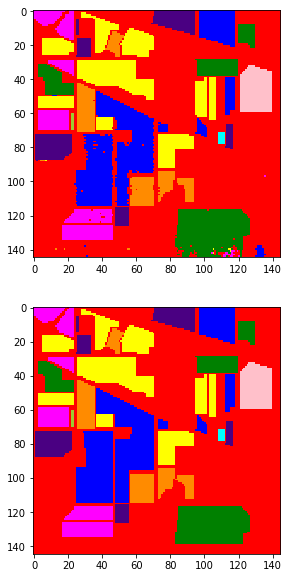

In [0]:
label_image = GANx.predict( X_train )
label_image = np.array(label_image[1])
y = []
for t in label_image:
  y.append(np.argmax(t))
label_image = np.array(y).reshape(145,145)
image_label_overlay = label2rgb(label_image)
fig, (ax1, ax2)  = plt.subplots(2,figsize=(10, 10))

ax1.imshow(image_label_overlay)
image_label_overlay = label2rgb(fullDataY.reshape(145,145))
ax2.imshow(image_label_overlay)


In [0]:
print( label_image.shape, fullDataY.shape)

In [0]:
pd.DataFrame(data=fullDataY).to_csv("y.csv")